# 地理空间数据--栅格

上一节，我们仔细研究了矢量数据，矢量数据使用点线面来表示地理要素的位置和形状，栅格数据则是像素矩阵或者是单元格的集合，形成一张图片。其中每个像素（单元格）都包含一个值，该值表示矩阵覆盖区域的特征、现象，例如类别、高度或光谱值等等。而其中的类别则可以是湖泊、城市或道路等土地利用类。高度（距离）则可表示平均海平面以上的表面高程，可以用来派生出坡度、坡向和流域属性。光谱值可在卫星影像和航空摄影中表示光反射系数和颜色。

![](../img/raster_dataset.png)

我们知道，对于一片区域，矢量数据可以表示其中的特征（点线面），不过对于区域上的其他特征可能难以使用适量特征来表示。例如下图中所示草地在颜色和覆盖密度方面有很多变化。在每个草地区域周围制作一个面很容易，但是将要素简化为单个面会丢失很多关于草地的信息。这是因为当我们给一个向量特征属性值时，它们适用于整个特征，所以向量不是很擅长表示特征内的不均匀等特性。因此使用栅格数据表示这些特征内部部分。

![](../img/landscape_geometry.jpg)

可以通过多种方式获取栅格数据，例如常见的航空摄影和卫星图像。

![](../img/csir_station.jpg)

接下来我们介绍两种比较常见的数据格式，一个是tif，一个是netcdf。

- 我们通过数字高程模型（Digital Elevation Model，DEM）数据文件来介绍tif，DEM是通过有限的地形高程数据实现对地面地形的数字化模拟（即地形表面形态的数字化表达）。
- NetCDF(network Common Data Form)网络通用数据格式是一种面向数组型并适于网络共享的数据的描述和编码标准。目前，NetCDF广泛应用于大气科学、水文、海洋学、环境模拟、地球物理等诸多领域。`.nc`是其数据拓展名。

## 1 TIF

以下是不同空间分辨率DEM的数据显示示例。

![](../img/dem_diff_resolution.png)

tif全称是Tagged Image File Format，文件扩展名为tif或tiff，是一种用于存储栅格图像的文件格式。

平台提供了一个下载DEM的工具 -- wis_downloader 工具包，设置经纬度即可下载

In [1]:
#导入工具
from wis_downloader import alos_dem
#根据四至范围搜索dem下载链接
hrefs=alos_dem.search(bbox=[120.58,38.43,123.31,40.12])#此为大连市的经纬度，大家可思考一下四个数字对应的方位
hrefs

['https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N040E123_DSM.tif',
 'https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N040E122_DSM.tif',
 'https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N040E121_DSM.tif',
 'https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N040E120_DSM.tif',
 'https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N039E123_DSM.tif',
 'https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N039E122_DSM.tif',
 'https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N039E121_DSM.tif',
 'https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N038E121_DSM.tif',
 'https://ai4edataeuwest.blob.core.windows.net/alos-dem/AW3D30_global/ALPSMLC30_N038E120_DSM.tif']

我们可以点击加载出来的链接下载DEM数据，也可以用命令下载。

我以通过以下命令将数据下载到'../data/dem'文件夹下

In [2]:
alos_dem.download(save_dir='../data/dem')

下载文件 ../data/dem\ALPSMLC30_N040E123_DSM.tif: 22504400it [02:05, 180017.52it/s]                                     
下载文件 ../data/dem\ALPSMLC30_N040E122_DSM.tif: 15214500it [00:05, 2756742.60it/s]                                    
下载文件 ../data/dem\ALPSMLC30_N040E121_DSM.tif: 1279800it [00:10, 121145.34it/s]                                      
下载文件 ../data/dem\ALPSMLC30_N040E120_DSM.tif: 11226500it [00:58, 192679.17it/s]                                     
下载文件 ../data/dem\ALPSMLC30_N039E123_DSM.tif: 2987700it [00:03, 775021.75it/s]                                      
下载文件 ../data/dem\ALPSMLC30_N039E122_DSM.tif: 10106700it [00:29, 346533.28it/s]                                     
下载文件 ../data/dem\ALPSMLC30_N039E121_DSM.tif: 6848200it [00:58, 117211.35it/s]                                      
下载文件 ../data/dem\ALPSMLC30_N038E121_DSM.tif: 1954100it [00:03, 590626.78it/s]                                      
下载文件 ../data/dem\ALPSMLC30_N038E120_DSM.tif: 177700it [00:01, 145259.25i

将DEM数据以.tif格式下载下来以后，我们可以使用图片类工具简单读取数据并将图片可视化。

这里推荐使用 [rioxarray](https://corteva.github.io/rioxarray/html/readme.html) 读取tif栅格数据

In [5]:
import rioxarray

In [6]:
imgpath='../data/dem/ALPSMLC30_N040E120_DSM.tif'
img=rioxarray.open_rasterio(imgpath)
img

<xarray.DataArray (band: 1, y: 3600, x: 3600)>
[12960000 values with dtype=int16]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 120.0 120.0 120.0 120.0 ... 121.0 121.0 121.0 121.0
  * y            (y) float64 41.0 41.0 41.0 41.0 41.0 ... 40.0 40.0 40.0 40.0
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:        Area
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1
    scale_factor:         1.0
    add_offset:           0.0

我们来可视化它

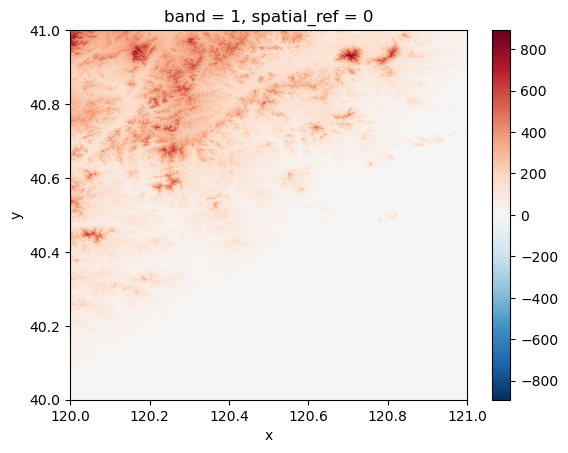

In [8]:
img.plot()

这里就不进一步展开了，大家了解到使用python能很方便地读取栅格数据即可。

## 2 NetCDF格式

我们会经常遇见`.nc`文件，也就是NetCDF格式文件。

- 从数学上来说，NetCDF存储的数据就是多个多自变量的单值函数。一个函数用公式来说就是f(x,y,z,…)=value；
- 函数的自变量x,y,z等在NetCDF中叫做维(dimension) 或坐标轴(axix)，
- 函数值value在NetCDF中叫做变量(Variables).

一个Netcdf文件的结构包括以下对象：

- 变量(Variables) ：变量对应着真实的物理数据。
- 维(dimension)：一个维对应着函数中的某个自变量，或者说函数图象中的一个坐标轴，典型地是三维，经纬度+时间。
- 属性(Attribute) ：属性是对变量值和维的具体物理含义的注释。

NetCDF 文件中的数据以**数组形式**存储。例如：某个位置处随时间变化的温度以一维数组的形式存储。某个区域内在指定时间的温度以二维数组的形式存储。

三维 (3D) 数据（如某个区域内随时间变化的温度）或四维 (4D) 数据（如某个区域内随时间和高度变化的温度）以一系列二维数组的形式存储。如下图所示：

![3d-data](../img/netcdf_3d.gif)
![4d-data](../img/netcdf_4d.gif)

读取`.nc`文件有很多种方法，这里演示python中最常用地使用`xarray`读取的方式。

我们通过`xarray`工具包中的`.open_dataset()`函数来读取`.nc`文件

具体使用的数据是公开数据集[CAMELS](https://ral.ucar.edu/solutions/products/camels)的流域径流时间序列数据（这里不用管它具体是什么，后续我们会有详细介绍），它原本格式是txt的，为了后面方便使用，我们已经将它处理到nc格式并放在平台服务器了，现在我们直接读取它。

首先，导入用来配置、读取CAMELS数据的hydrodataset包

In [1]:
import hydrodataset

接下来，我们需要配置CAMELS数据集的文件路径，在平台jupyterlab首页打开终端，然后输入以下命令打开hydrodataset配置文件：

```Shell
# 进入配置文件所在文件夹
cd ~/.hydrodataset
# 使用vim打开配置文件
vim settings.txt
```

打开后，按“i”键，将vim编辑器调整至INSERT模式，如下图所示：

![](../img/vim_insert.png)

然后输入和上图中一样的内容，即 `/ftproot`，ftproot是我们在服务器上放置公共数据的默认文件夹，处理好的CAMELS数据集文件都在这个文件夹下面。

然后再按“:”（注意是英文输入法下的冒号）进入命令模式，然后输入“wq”并按回车键，就能写入（即保存）并退出了。

![](../img/vim_wq.png)

现在数据已经配置好了，我们就能读取一个nc文件试试了。

In [10]:
import xarray as xr

In [11]:
dataset_dir = hydrodataset.ROOT_DIR

In [12]:
camels_streamflow = xr.open_dataset(dataset_dir.joinpath("camels","camels_us","camels_streamflow.nc"))
camels_streamflow

<xarray.Dataset>
Dimensions:     (basin: 671, time: 12784)
Coordinates:
  * basin       (basin) object '01013500' '01022500' ... '14362250' '14400000'
  * time        (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    streamflow  (basin, time) float64 ...

可以看见Netcdf文件的维度、坐标、属性与变量。

查看有哪些流域：

In [13]:
camels_streamflow.basin

<xarray.DataArray 'basin' (basin: 671)>
array(['01013500', '01022500', '01030500', ..., '14325000', '14362250',
       '14400000'], dtype=object)
Coordinates:
  * basin    (basin) object '01013500' '01022500' ... '14362250' '14400000'

后面我们会有更多例子来更详细介绍这些内容